## 1. Calidad de un vino

> a)  Carge los dos dataset en un único dataframe de pandas, además de agregar una columna indicando si es vino tinto o blanco. Describa el dataset a trabajar.

In [1]:
import pandas as pd
df_red = pd.read_csv("winequality-red.csv",sep=";")
df_red['type']='red'
df_white = pd.read_csv("winequality-white.csv",sep=";")
df_white['type']='white'
df = pd.concat([df_red,df_white], axis=0)


print(df.shape)
print(df_red.shape)
print(df_white.shape)


df.head()


(6497, 13)
(1599, 13)
(4898, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Hay 6497 datos en total, 1599 de vino tinto y 4898 de vino blanco. Hay 12 atributos, descritos en la referencia como:
- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol
- 13 - type

y la variable dependiente
- 12 - quality (score between 0 and 10)


> b) Aborde este problema como si fuera de clasificación con multiples clases para predecir el valor de calidad de un vino, es decir, utilice las distintas caracterı́sticas fisioquı́micas presentes en los datos para estimar la etiqueta ¿Cuántas clases son y cuántos ejemplos hay por clase? ¿Qué sucede con predecir si un vino tiene calidad mínima (0) o máxima(10)? Además para el propósito académico de esta actividad cree un conjunto de pruebas (20%) para evaluar la generalización final del modelo y otro de validación (20%) si estima conveniente. 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



y = df["quality"].values
df.drop("quality",axis=1,inplace=True)

X = (df.drop("type",axis=1)).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)



std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)
X_val = std.transform(X_val)


> c) Entrene un solo Árbol de Clasificación de múltiples niveles para resolver el problema. Defina un Árbol no regularizado (como el que no tiene límites en su profundidad) y otro Árbol regularizado (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar split o el número mínimo de datos en cada hoja), recuerde que las decisiones no pueden ser basadas mirando el conjunto de pruebas. Debido al desbalanceo que se produce en las clases mida la métrica F1-score [2] sobre el conjunto de entrenamiento y de pruebas.

In [4]:
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.metrics import f1_score

model = Tree()

model.fit(X_train, y_train)


print("accuracy no regularizado train:",model.score(X_train, y_train))
print("accuracy no regularizado val  :",model.score(X_val, y_val))
print("f1 no regularizado train      :",f1_score(model.predict(X_train),y_train, average="weighted"))
print("f1 no regularizado val        :",f1_score(model.predict(X_val),y_val, average="weighted"))

accuracy no regularizado train: 1.0
accuracy no regularizado val  : 0.5861538461538461
f1 no regularizado train      : 1.0
f1 no regularizado val        : 0.590512009140027


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


The best parameters are {'max_depth': 5, 'min_samples_leaf': 26} with a score of 0.52


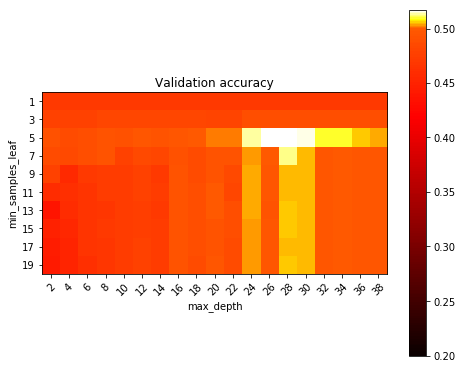

In [7]:
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
# funcion auxiliar

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


# #############################################################################
# Train classifiers

max_depth_range = range(1,20,2)
min_samples_leaf_range = range(2,40,2)
param_grid = dict(min_samples_leaf=min_samples_leaf_range, max_depth=max_depth_range)
grid = GridSearchCV(Tree(), param_grid=param_grid)
grid.fit(X_val, y_val)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))



scores = grid.cv_results_['mean_test_score'].reshape(len(max_depth_range),len(min_samples_leaf_range))

# Draw heatmap

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.5))
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')
plt.colorbar()
plt.xticks(np.arange(len(min_samples_leaf_range)), min_samples_leaf_range, rotation=45)
plt.yticks(np.arange(len(max_depth_range)), max_depth_range)
plt.title('Validation accuracy')
plt.show()



In [8]:

model = Tree(max_depth=5,min_samples_leaf=26)

model.fit(X_train, y_train)


print("accuracy regularizado train:",model.score(X_train, y_train))
print("accuracy regularizado val  :",model.score(X_val, y_val))
print("f1 regularizado train      :",f1_score(model.predict(X_train),y_train, average="weighted"))
print("f1 regularizado val        :",f1_score(model.predict(X_val),y_val, average="weighted"))

accuracy regularizado train: 0.5732614831921992
accuracy regularizado val  : 0.5176923076923077
f1 regularizado train      : 0.6013710162498105
f1 regularizado val        : 0.5476839625333698


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Se entrenan dos arboles, uno no regularizado y otro con profundida maxima 10 y minimo de datos por hoja 20. Como es de esperar el arbol no regularizado sufre el maximo overfitting posible, ya que la regla que construye es simplemente asignarle la etiqueta al dato de entrenamiento.

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en c)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro.

C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


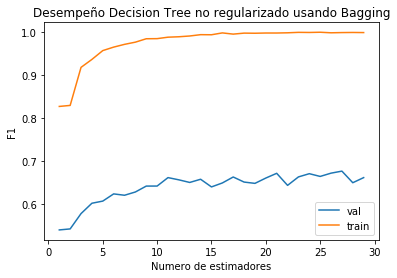

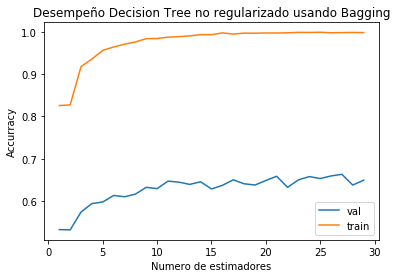

In [23]:
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt


f1_val=[]
f1_train=[]
acc_val=[]
acc_train=[]

rango=30

for i in range(1,rango):
    model = BaggingClassifier(base_estimator=Tree(), n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)

    f1_val.append(f1_score(model.predict(X_val), y_val, average="weighted"))
    f1_train.append(f1_score(model.predict(X_train), y_train, average="weighted"))
    acc_val.append(model.score(X_val, y_val))
    acc_train.append(model.score(X_train, y_train))
    
    
plt.title("Desempeño Decision Tree no regularizado usando Bagging")
plt.xlabel("Numero de estimadores")
plt.ylabel("F1")

plt.plot(range(1,rango),f1_val,label="val")
plt.plot(range(1,rango),f1_train,label="train")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño Decision Tree no regularizado usando Bagging")
plt.xlabel("Numero de estimadores")
plt.ylabel("Accurracy")

plt.plot(range(1,rango),acc_val,label="val")
plt.plot(range(1,rango),acc_train,label="train")
plt.legend(loc="best")
plt.show()

In [25]:
print("Mejor F1 val=", max(f1_val))
print("Mejor acc val =", acc_val[f1_val.index(max(f1_val))])

Mejor F1 val= 0.6764059758119572
Mejor acc val = 0.6630769230769231


Hay una clara mejora en el desempeño al aumentar el numero de estimadores, esto debido a que se reduce la varianza del modelo al aumentar las instancias de este. Esto cambio es mucho mayor para el caso de los arboles de decision debido a su alta suspetibilidad al overfitting. Tambien se alcanza el valle a aproximadamente los 10 estimadores.

C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


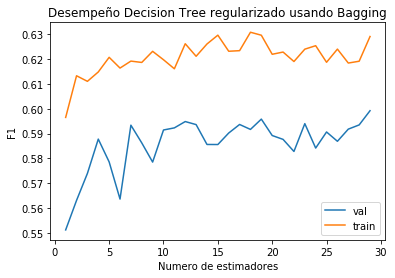

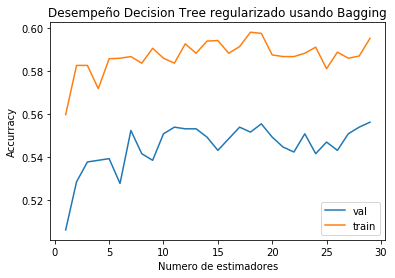

In [26]:
f1_val=[]
f1_train=[]
acc_val=[]
acc_train=[]

rango=30

for i in range(1,rango):
    model = BaggingClassifier(base_estimator=Tree(max_depth=5,min_samples_leaf=26), n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)

    f1_val.append(f1_score(model.predict(X_val), y_val, average="weighted"))
    f1_train.append(f1_score(model.predict(X_train), y_train, average="weighted"))
    acc_val.append(model.score(X_val, y_val))
    acc_train.append(model.score(X_train, y_train))
    
    
plt.title("Desempeño Decision Tree regularizado usando Bagging")
plt.xlabel("Numero de estimadores")
plt.ylabel("F1")

plt.plot(range(1,rango),f1_val,label="val")
plt.plot(range(1,rango),f1_train,label="train")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño Decision Tree regularizado usando Bagging")
plt.xlabel("Numero de estimadores")
plt.ylabel("Accurracy")

plt.plot(range(1,rango),acc_val,label="val")
plt.plot(range(1,rango),acc_train,label="train")
plt.legend(loc="best")
plt.show()

In [28]:
print("Mejor F1 val=", max(f1_val))
print("Mejor acc val =", acc_val[f1_val.index(max(f1_val))])

Mejor F1 val= 0.5991968536910594
Mejor acc val = 0.5561538461538461


Al igual que el caso no regularizado, hay un aumento substancial en el desempeño, sin embargo, este alcanza su valle a los 2 o 3 estimadores, esto debido a que la regularizacion ya reduce la varianza del modelo, esto implica que el efecto del bagging es menor.

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en c) ¿Se visualiza overfitting? ¿Qué técnica se utiliza, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del F1-score de entrenamiento y de pruebas en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

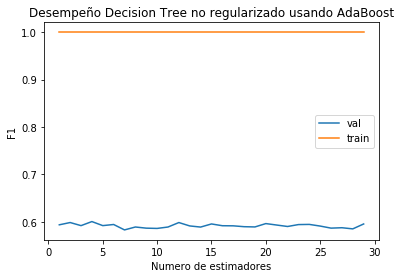

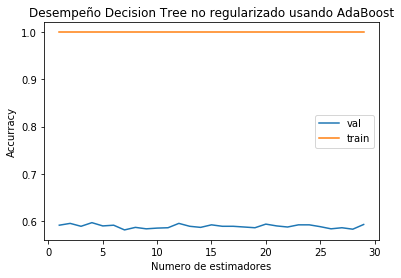

In [29]:
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt


f1_val=[]
f1_train=[]
acc_val=[]
acc_train=[]


rango=30

for i in range(1,rango):
    model = AdaBoostClassifier(base_estimator=Tree(), n_estimators=i)
    model.fit(X_train,y_train)

    f1_val.append(f1_score(model.predict(X_val), y_val, average="weighted"))
    f1_train.append(f1_score(model.predict(X_train), y_train, average="weighted"))
    acc_val.append(model.score(X_val, y_val))
    acc_train.append(model.score(X_train, y_train))
    
    
plt.title("Desempeño Decision Tree no regularizado usando AdaBoost")
plt.xlabel("Numero de estimadores")
plt.ylabel("F1")

plt.plot(range(1,rango),f1_val,label="val")
plt.plot(range(1,rango),f1_train,label="train")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño Decision Tree no regularizado usando AdaBoost")
plt.xlabel("Numero de estimadores")
plt.ylabel("Accurracy")

plt.plot(range(1,rango),acc_val,label="val")
plt.plot(range(1,rango),acc_train,label="train")
plt.legend(loc="best")
plt.show()



In [30]:
print("Mejor F1 val=", max(f1_val))
print("Mejor acc val =", acc_val[f1_val.index(max(f1_val))])

Mejor F1 val= 0.6002628400461126
Mejor acc val = 0.5961538461538461


AdaBoost no tiene ningun efecto en los resultados esto es extraño ya que se espera una mejora significativa. Esto debido a que el modelo final es un promedio ponderado de modelos que se entrenan adaptativamente.



In [44]:

f1_val=[]
f1_train=[]
acc_val=[]
acc_train=[]

rango=30

for i in range(1,rango):
    model = AdaBoostClassifier(base_estimator=Tree(max_depth=5,min_samples_leaf=26), n_estimators=i)
    model.fit(X_train,y_train)

    f1_val.append(f1_score(model.predict(X_val), y_val, average="weighted"))
    f1_train.append(f1_score(model.predict(X_train), y_train, average="weighted"))
    acc_val.append(model.score(X_val, y_val))
    acc_train.append(model.score(X_train, y_train))
    
    


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarn

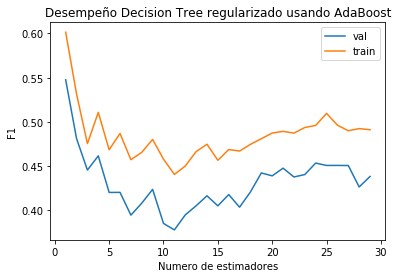

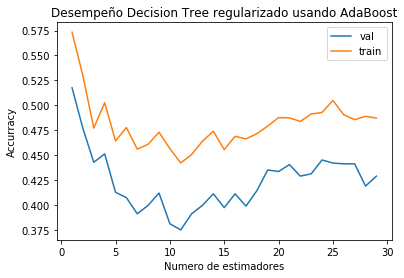

In [45]:
plt.title("Desempeño Decision Tree regularizado usando AdaBoost")
plt.xlabel("Numero de estimadores")
plt.ylabel("F1")

plt.plot(range(1,rango),f1_val,label="val")
plt.plot(range(1,rango),f1_train,label="train")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño Decision Tree regularizado usando AdaBoost")
plt.xlabel("Numero de estimadores")
plt.ylabel("Accurracy")

plt.plot(range(1,rango),acc_val,label="val")
plt.plot(range(1,rango),acc_train,label="train")
plt.legend(loc="best")
plt.show()

In [46]:
print("Mejor F1 val=", max(f1_val))
print("Mejor acc val =", acc_val[f1_val.index(max(f1_val))])

Mejor F1 val= 0.5476839625333698
Mejor acc val = 0.5176923076923077


Peor aun, para este caso los resultados son peores que el caso sin utilizar AdaBoost, se desconoce la razon especifica. Se concluye que utilizar bagging es mucho mejor a utilizar AdaBoost para arboles de decision.



> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen el F1-score de entrenamiento y de pruebas en función de este hiper-parámetro.



In [38]:
from sklearn.ensemble import RandomForestClassifier

f1_val=[]
f1_train=[]
acc_val=[]
acc_train=[]


rango=30

for i in range(1,rango):
    Forest_noregular = RandomForestClassifier(n_estimators=i, n_jobs=-1)
    Forest_noregular.fit(X_train,y_train)

    f1_val.append(f1_score(Forest_noregular.predict(X_val), y_val, average="weighted"))
    f1_train.append(f1_score(Forest_noregular.predict(X_train), y_train, average="weighted"))
    acc_val.append(Forest_noregular.score(X_val, y_val))
    acc_train.append(Forest_noregular.score(X_train, y_train))
    
    


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarn

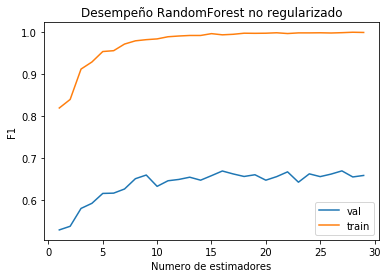

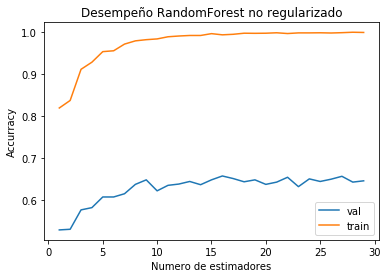

In [35]:
plt.title("Desempeño RandomForest no regularizado")
plt.xlabel("Numero de estimadores")
plt.ylabel("F1")

plt.plot(range(1,rango),f1_val_noreg,label="val")
plt.plot(range(1,rango),f1_train_noreg,label="train")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño RandomForest no regularizado")
plt.xlabel("Numero de estimadores")
plt.ylabel("Accurracy")

plt.plot(range(1,rango),acc_val_noreg,label="val")
plt.plot(range(1,rango),acc_train_noreg,label="train")
plt.legend(loc="best")
plt.show()



In [39]:
print("Mejor F1 val=", max(f1_val))
print("Mejor acc val =", acc_val[f1_val.index(max(f1_val))])

Mejor F1 val= 0.6795424611405245
Mejor acc val = 0.666923076923077


In [40]:
from sklearn.ensemble import RandomForestClassifier

f1_val=[]
f1_train=[]
acc_val=[]
acc_train=[]

rango=30

for i in range(1,rango):
    model = RandomForestClassifier(n_estimators=i,max_depth=5,min_samples_leaf=26, n_jobs=-1)
    model.fit(X_train,y_train)

    f1_val.append(f1_score(model.predict(X_val), y_val, average="weighted"))
    f1_train.append(f1_score(model.predict(X_train), y_train, average="weighted"))
    acc_val.append(model.score(X_val, y_val))
    acc_train.append(model.score(X_train, y_train))
    
    


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarn

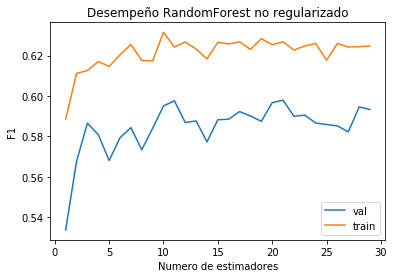

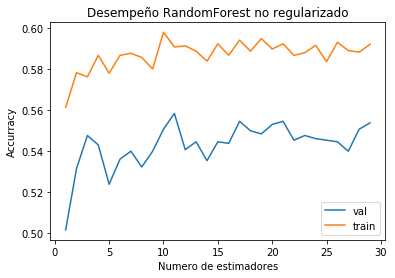

In [37]:
plt.title("Desempeño RandomForest no regularizado")
plt.xlabel("Numero de estimadores")
plt.ylabel("F1")

plt.plot(range(1,rango),f1_val_reg,label="val")
plt.plot(range(1,rango),f1_train_reg,label="train")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño RandomForest no regularizado")
plt.xlabel("Numero de estimadores")
plt.ylabel("Accurracy")

plt.plot(range(1,rango),acc_val_reg,label="val")
plt.plot(range(1,rango),acc_train_reg,label="train")
plt.legend(loc="best")
plt.show()


In [41]:
print("Mejor F1 val=", max(f1_val))
print("Mejor acc val =", acc_val[f1_val.index(max(f1_val))])

Mejor F1 val= 0.5990824053527501
Mejor acc val = 0.546923076923077


El comportamiento del Random Forest es extremadamente parecido al de bagging, esto es de esperar debido a que el random forest es una variacion de del bagging donde cada nodo utiliza un subconjunto de los atributos. Sin embargo, el random forest  obtuvo resultados levemente mejores al caso de bagging solo, esto es ya que el random forest hace una eleccion aleatoria de atributos 

>g) Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compárelo con el error calculado sobre el conjunto de pruebas y validación (o en su defecto cross validation).

In [20]:
Forest_regular = RandomForestClassifier(n_estimators=2,max_depth=5,min_samples_leaf=26, n_jobs=-1)
Forest_regular.fit(X_train,y_train)
oob_error = 1 - Forest_regular.oob_score
test_error = 1- Forest_regular.score(X_test,y_test)
val_error = 1- Forest_regular.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
print("Test error: ",test_error)

OOB error:  1
Val error:  0.4623076923076923
Test error:  0.4669230769230769


>h) Entrene alguna otra máquina de aprendizaje, elegida por usted de entre todas las vistas en el curso, para resolver el problema. Elija los hiper-parámetros que estime convenientes intentando aumentar el F1-score obtenido por los algoritmos anteriores ¿Se logra una mejora? ¿Por qué?

Se entrena una red neuronal con una capa escondida con 100 neuronas, y utilizando dropout durante el entrenamiento.

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)

model = Sequential()
Dropout(0.4, noise_shape=None, seed=None)
model.add(Dense(100, input_dim=X_train.shape[1], activation="sigmoid"))
Dropout(0.4, noise_shape=None, seed=None)
model.add(Dense(y_binary.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.3), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_binary, epochs=200, batch_size=32, verbose=1,validation_data=(X_val,y_val_binary))

model.summary()

y_pred_val =  np.argmax(model.predict(X_val),axis=-1)
y_pred_train =  np.argmax(model.predict(X_train),axis=-1)

Train on 3897 samples, validate on 1300 samples
Epoch 1/200
3897/3897 [==============================] - 1s 159us/step - loss: 1.2639 - acc: 0.4349 - val_loss: 1.2205 - val_acc: 0.4238
Epoch 2/200
3897/3897 [==============================] - 0s 22us/step - loss: 1.1366 - acc: 0.4896 - val_loss: 1.1769 - val_acc: 0.5038
Epoch 3/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.1070 - acc: 0.5250 - val_loss: 1.1598 - val_acc: 0.4862
Epoch 4/200
3897/3897 [==============================] - 0s 24us/step - loss: 1.0985 - acc: 0.5242 - val_loss: 1.1351 - val_acc: 0.5262
Epoch 5/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.0926 - acc: 0.5278 - val_loss: 1.1216 - val_acc: 0.5208
Epoch 6/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.0883 - acc: 0.5304 - val_loss: 1.1235 - val_acc: 0.5131
Epoch 7/200
3897/3897 [==============================] - 0s 20us/step - loss: 1.0783 - acc: 0.5294 - val_loss: 1.1122 - val_acc: 0.5285

3897/3897 [==============================] - 0s 21us/step - loss: 1.0196 - acc: 0.5432 - val_loss: 1.1125 - val_acc: 0.5085
Epoch 61/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.0220 - acc: 0.5414 - val_loss: 1.0880 - val_acc: 0.5169
Epoch 62/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.0181 - acc: 0.5425 - val_loss: 1.0818 - val_acc: 0.5315
Epoch 63/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.0200 - acc: 0.5448 - val_loss: 1.0818 - val_acc: 0.5231
Epoch 64/200
3897/3897 [==============================] - 0s 20us/step - loss: 1.0172 - acc: 0.5412 - val_loss: 1.0863 - val_acc: 0.5262
Epoch 65/200
3897/3897 [==============================] - 0s 21us/step - loss: 1.0163 - acc: 0.5445 - val_loss: 1.0859 - val_acc: 0.5208
Epoch 66/200
3897/3897 [==============================] - 0s 20us/step - loss: 1.0172 - acc: 0.5443 - val_loss: 1.0898 - val_acc: 0.5208
Epoch 67/200
3897/3897 [==============================

Epoch 120/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.9585 - acc: 0.5812 - val_loss: 1.0768 - val_acc: 0.5254
Epoch 121/200
3897/3897 [==============================] - 0s 21us/step - loss: 0.9572 - acc: 0.5802 - val_loss: 1.0639 - val_acc: 0.5308
Epoch 122/200
3897/3897 [==============================] - 0s 21us/step - loss: 0.9541 - acc: 0.5817 - val_loss: 1.1077 - val_acc: 0.5077
Epoch 123/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.9541 - acc: 0.5897 - val_loss: 1.0693 - val_acc: 0.5238
Epoch 124/200
3897/3897 [==============================] - 0s 21us/step - loss: 0.9569 - acc: 0.5756 - val_loss: 1.0878 - val_acc: 0.5292
Epoch 125/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.9535 - acc: 0.5825 - val_loss: 1.0706 - val_acc: 0.5354
Epoch 126/200
3897/3897 [==============================] - 0s 22us/step - loss: 0.9566 - acc: 0.5787 - val_loss: 1.0695 - val_acc: 0.5323
Epoch 127/200
3897/3897 [=========

3897/3897 [==============================] - 0s 22us/step - loss: 0.8961 - acc: 0.6069 - val_loss: 1.0807 - val_acc: 0.5369
Epoch 180/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.8945 - acc: 0.6141 - val_loss: 1.0900 - val_acc: 0.5415
Epoch 181/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.8903 - acc: 0.6118 - val_loss: 1.0766 - val_acc: 0.5392
Epoch 182/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.8880 - acc: 0.6135 - val_loss: 1.0749 - val_acc: 0.5431
Epoch 183/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.8912 - acc: 0.6097 - val_loss: 1.0853 - val_acc: 0.5438
Epoch 184/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.8896 - acc: 0.6120 - val_loss: 1.0757 - val_acc: 0.5408
Epoch 185/200
3897/3897 [==============================] - 0s 20us/step - loss: 0.8894 - acc: 0.6082 - val_loss: 1.0738 - val_acc: 0.5369
Epoch 186/200
3897/3897 [=======================

In [84]:
from sklearn.metrics import accuracy_score

print("f1 no regularizado train      :",f1_score(y_pred_train,y_train, average="weighted"))
print("f1 no regularizado val        :",f1_score(y_pred_val,y_val, average="weighted"))

f1 no regularizado train      : 0.6193452422828315
f1 no regularizado val        : 0.5481116466288513


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


El estadistico F1 es de 0.548 para el conjunto de validacion, lo que peor a lo obtenido anteriormente para los otros modelos, estos tenian valores superiores a 0.6, lo mas probable es debido a que la red utilizada es demasiado basica y se necesita alguna tecnica para mejorarle. 

>i) Compare y analice las distintas maneras con las que se resolvió el problema definido en b), por ejemplo incluya las decisiones que conlleva y los resultados que reflejan.

Se construye la tabla resumen con los mejores resultados en el conjunto de validacion:



|    |Tree No Regular |Tree Regular | Bagging No Regular |Bagging Regular | AdaBoost No Regular| AdaBoost Regular| Random Forest No Regular| Random Forest Regular| Red Neuronal|
|------    |------    |------| ------|-|-|
|   F1    | 0.590|0.547|0.676|0.599|0.600|0.547|0.679|0.599|0.548
|   Acc    |0.586|0.517|0.663| 0.556| 0.596|0.517|0.666|0.546|0.530

Se observa que el random forest no regular supera al resto de los modelos, a parte de esto, los metodos no regularizados superan a los modelos regularizados consistentemente, esto debido a que las distintas tecnicas buscan reducir la varianza del modelo, la que es muy alta por no estar regularizados.

Por otro lado, AdaBoost Regularizado es el peor metodo, se desconoce la razon.


>j) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo Bagging realiza el voto de la mayoría para clasificación y promedio para regresión, AdaBoost realiza una combinación ponderada de cada clasificador dependiendo de su habilidad (desempeño para clasificar el conjunto de entrenamiento).
